<a href="https://colab.research.google.com/github/rohan30497/EEG_Signal_Processing/blob/main/Epilepsy_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
!pip install --upgrade mne


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 44.2 MB/s eta 0:00:00


In [ ]:
!pip install mne -q

Paper link https://www.biorxiv.org/content/10.1101/324954v1.full

Datasets were collected using EMOTIVE with the 128 Hz sampling frequency.
There are two differnt dataset collected in Guinea Bissau (97 subjects) and Nigeria (112 subjects).
Here we are dealing with data collected in Guinea Bissau

In [ ]:
!wget https://zenodo.org/record/1252141/files/EEGs_Guinea-Bissau.zip

--2023-10-12 06:06:48--  https://zenodo.org/record/1252141/files/EEGs_Guinea-Bissau.zip
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 153973086 (147M) [application/octet-stream]
Saving to: ‘EEGs_Guinea-Bissau.zip’

EEGs_Guinea-Bissau. 100%[===================>] 146.84M   379KB/s    in 6m 40s  

2023-10-12 06:13:30 (376 KB/s) - ‘EEGs_Guinea-Bissau.zip’ saved [153973086/153973086]



In [ ]:
#unzip the files
from zipfile import ZipFile
data = ZipFile('EEGs_Guinea-Bissau.zip')
data.extractall()

In [ ]:
meta_df=pd.read_csv('https://zenodo.org/record/1252141/files/metadata_guineabissau.csv')
meta_df.head()

,subject.id,Group,Eyes.condition,Remarks,recordedPeriod,startTime
0,1,Epilepsy,closed-3min-then-open-2min,by 45s reposition electrodes,301,27/5/2020 14:33
1,2,Control,open-3min-then-closed-2min,NaN,309,26/5/2020 22:44
2,3,Epilepsy,closed-3min-then-open-2min,NaN,309,27/5/2020 14:26
3,4,Epilepsy,closed-3min-then-open-2min,"Green lights not shown, but good EEG traces",299,27/5/2020 15:23
4,5,Control,closed-3min-then-open-2min,NaN,302,23/5/2020 19:09


In [ ]:
#grouping the df based on group labels

EP_sub=meta_df['subject.id'][meta_df['Group']=='Epilepsy']
CT_sub=meta_df['subject.id'][meta_df['Group']=='Control']


In [ ]:
#Read csv files
Epilepsy=[pd.read_csv('EEGs_Guinea-Bissau/signal-{}.csv.gz'.format(i), compression='gzip') for i in  EP_sub]
Control=[pd.read_csv('EEGs_Guinea-Bissau/signal-{}.csv.gz'.format(i), compression='gzip') for i in  CT_sub]

In [ ]:
Epilepsy[1].head()

,Unnamed: 0,AF3,AF4,F3,F4,F7,F8,FC5,FC6,O1,...,CQ_F3,CQ_P7,CQ_P8,CQ_F4,CQ_AF3,CQ_FC5,CQ_O1,CQ_T8,CQ_F8,CQ_DRL
0,1,3813.333333,3172.820513,3724.102564,3021.538462,3931.282051,3407.692308,4247.692308,3508.205128,3845.641026,...,4,4,4,4,4,4,4,4,4,4
1,2,3813.333333,3165.641026,3729.743590,3022.564103,3924.615385,3401.025641,4250.769231,3506.153846,3845.128205,...,4,4,4,4,4,4,4,4,4,4
2,3,3813.333333,3163.589744,3730.769231,3024.615385,3924.615385,3397.435897,4249.230769,3503.589744,3845.128205,...,4,4,4,4,4,4,4,4,4,4
3,4,3815.384615,3167.692308,3729.230769,3023.076923,3928.205128,3397.948718,4247.692308,3498.974359,3845.128205,...,4,4,4,4,4,4,4,4,4,4
4,5,3816.410256,3162.564103,3727.692308,3013.333333,3933.846154,3393.333333,4253.333333,3494.871795,3845.641026,...,4,4,4,4,4,4,4,4,4,4


As 14-channel electrodes are used for recording so we will remove the extra columns from the df

In [ ]:
Epilepsy=[i.iloc[:,1:15] for i in  Epilepsy]
Control=[i.iloc[:,1:15] for i in  Control]


Convert the data stored in DF into MNE object

In [ ]:
import mne
def convertDF2MNE(sub):
    info = mne.create_info(list(sub.columns), ch_types=['eeg'] * len(sub.columns), sfreq=128)
    info.set_montage('standard_1020')
    data=mne.io.RawArray(sub.T, info)
    data.set_eeg_reference()
    data.filter(l_freq=0.1,h_freq=45)
    epochs=mne.make_fixed_length_epochs(data,duration=5,overlap=1)
    epochs=epochs.drop_bad()

    return epochs

In [ ]:

%%capture
#Convert each dataframe to mne object
Epilepsy=[convertDF2MNE(i) for i in  Epilepsy]
Control=[convertDF2MNE(i) for i in  Control]

In [ ]:

%%capture
#concatenate the epochs
Epilepsy_epochs=mne.concatenate_epochs(Epilepsy)
Control_epochs=mne.concatenate_epochs(Control)


Create label and group

In [ ]:
Epilepsy_group=np.concatenate([[i]*len(Epilepsy[i]) for i in range(len(Epilepsy))])#create a list of list where each sub list corresponds to subject_no
Control_group=np.concatenate([[i]*len(Control[i]) for i in range(len(Control))])#create a list of list where each sub list corresponds to subject_no

Epilepsy_label=np.concatenate([[0]*len(Epilepsy[i]) for i in range(len(Epilepsy))])
Control_label=np.concatenate([[1]*len(Control[i]) for i in range(len(Control))])

In [ ]:
Epilepsy_group.shape,Epilepsy_label.shape, Control_group.shape,Control_label.shape


((3995,), (3995,), (3461,), (3461,))

In [ ]:
#combine data
data=mne.concatenate_epochs([Epilepsy_epochs,Control_epochs])
group=np.concatenate((Epilepsy_group,Control_group))
label=np.concatenate((Epilepsy_label,Control_label))
print(len(data),len(group),len(label))

Not setting metadata
7456 matching events found
No baseline correction applied
7456 7456 7456


##Feature Extraction

We are using FFT for feature extraction

In [ ]:
import numpy as np
from scipy.fft import fft

def eeg_fft_band(epochs, sfreq):
    """EEG relative power band feature extraction using FFT.

    This function takes an `mne.Epochs` object and creates EEG features based
    on relative power in specific frequency bands that are compatible with
    scikit-learn.

    Parameters
    ----------
    epochs : mne.Epochs
        The data.
    sfreq : float
        The sampling frequency of the data.

    Returns
    -------
    X : numpy array of shape [n_samples, n_bands]
        Transformed data where n_bands is the number of specified frequency bands.
    """
    # Define specific frequency bands
    FREQ_BANDS = {"delta": [0.5, 4.5],
                  "theta": [4.5, 8.5],
                  "alpha": [8.5, 11.5],
                  "sigma": [11.5, 15.5],
                  "beta": [15.5, 30],
                  "gamma": [30, 45]}

    n_channels = len(epochs.info['ch_names'])

    X = []  # Initialize a list to store the FFT features for each band
    for fmin, fmax in FREQ_BANDS.values():
        # Compute the FFT of the EEG data
        fft_data = fft(epochs.get_data()[:, :n_channels, :])
        freqs = np.fft.fftfreq(epochs.get_data().shape[2], 1.0 / sfreq)

        # Extract FFT amplitudes in the specified frequency band
        fft_band = np.mean(np.abs(fft_data[:, :, (freqs >= fmin) & (freqs < fmax)]), axis=2)
        X.append(fft_band)

    # Concatenate the mean FFT amplitudes for each band into a single feature vector
    X = np.concatenate(X, axis=1)

    return X


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
X = data.get_data()  # Assuming data is an mne.Epochs object
y = label

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Define a CNN model
model = keras.Sequential()
model.add(keras.layers.Reshape((X_train.shape[1], X_train.shape[2], 1), input_shape=(X_train.shape[1], X_train.shape[2], 1)))
model.add(keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(2, activation='softmax'))  # 2 output classes (Epilepsy and Control)

In [ ]:
# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10
187/187 [==============================] - 14s 10ms/step - loss: 32.0008 - accuracy: 0.4961 - val_loss: 0.6916 - val_accuracy: 0.5503
Epoch 2/10
187/187 [==============================] - 2s 8ms/step - loss: 0.6918 - accuracy: 0.5320 - val_loss: 0.6899 - val_accuracy: 0.5503
Epoch 3/10
187/187 [==============================] - 2s 9ms/step - loss: 0.6913 - accuracy: 0.5322 - val_loss: 0.6890 - val_accuracy: 0.5503
Epoch 4/10
187/187 [==============================] - 2s 9ms/step - loss: 0.6912 - accuracy: 0.5322 - val_loss: 0.6891 - val_accuracy: 0.5503
Epoch 5/10
187/187 [==============================] - 1s 8ms/step - loss: 0.6911 - accuracy: 0.5322 - val_loss: 0.6889 - val_accuracy: 0.5503
Epoch 6/10
187/187 [==============================] - 1s 7ms/step - loss: 0.6911 - accuracy: 0.5322 - val_loss: 0.6889 - val_accuracy: 0.5503
Epoch 7/10
187/187 [==============================] - 1s 7ms/step - loss: 0.6912 - accuracy: 0.5322 - val_loss: 0.6886 - val_accuracy: 0.5503
Epo

In [ ]:
# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

47/47 [==============================] - 0s 3ms/step


In [ ]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_classes)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 55.03%


In [ ]:
# Generate a classification report
report = classification_report(y_test, y_pred_classes)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.55      1.00      0.71       821
           1       0.00      0.00      0.00       671

    accuracy                           0.55      1492
   macro avg       0.28      0.50      0.35      1492
weighted avg       0.30      0.55      0.39      1492



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Generate a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[821   0]
 [671   0]]


Applying CV

In [ ]:


# Define the number of folds (K)
n_splits = 5

# Initialize lists to store results from each fold
accuracy_scores = []

# Create a K-fold cross-validation splitter
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Split the data into a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Iterate over the folds
for train_index, val_index in kf.split(X_train, y_train):
    X_train_fold, X_val = X_train[train_index], X_train[val_index]
    y_train_fold, y_val = y_train[train_index], y_train[val_index]

    # Define and compile the CNN model
    model = keras.Sequential()
    model.add(keras.layers.Reshape((X_train_fold.shape[1], X_train_fold.shape[2], 1), input_shape=(X_train_fold.shape[1], X_train_fold.shape[2], 1)))
    model.add(keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dense(2, activation='softmax'))  # 2 output classes (Epilepsy and Control)

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Train the model
    model.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, validation_data=(X_val, y_val))

    # Make predictions on the validation set
    y_val_pred = np.argmax(model.predict(X_val), axis=1)

    # Calculate and store the accuracy for this fold
    accuracy = accuracy_score(y_val, y_val_pred)
    accuracy_scores.append(accuracy)

# Calculate the mean accuracy across all folds
mean_accuracy = np.mean(accuracy_scores)
print("Mean Cross-Validation Accuracy:", mean_accuracy)

# Evaluate the model on the separate test set
y_test_pred = np.argmax(model.predict(X_test), axis=1)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Set Accuracy:", test_accuracy)


Epoch 1/10
150/150 [==============================] - 4s 12ms/step - loss: 21.9021 - accuracy: 0.5322 - val_loss: 0.6921 - val_accuracy: 0.5323
Epoch 2/10
150/150 [==============================] - 1s 9ms/step - loss: 0.6917 - accuracy: 0.5322 - val_loss: 0.6914 - val_accuracy: 0.5323
Epoch 3/10
150/150 [==============================] - 1s 8ms/step - loss: 0.6914 - accuracy: 0.5322 - val_loss: 0.6912 - val_accuracy: 0.5323
Epoch 4/10
150/150 [==============================] - 2s 11ms/step - loss: 0.6912 - accuracy: 0.5322 - val_loss: 0.6911 - val_accuracy: 0.5323
Epoch 5/10
150/150 [==============================] - 2s 13ms/step - loss: 0.6911 - accuracy: 0.5322 - val_loss: 0.6911 - val_accuracy: 0.5323
Epoch 6/10
150/150 [==============================] - 2s 14ms/step - loss: 0.6912 - accuracy: 0.5322 - val_loss: 0.6911 - val_accuracy: 0.5323
Epoch 7/10
150/150 [==============================] - 2s 13ms/step - loss: 0.6911 - accuracy: 0.5322 - val_loss: 0.6911 - val_accuracy: 0.5323


In [ ]:
# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

47/47 [==============================] - 0s 3ms/step


In [ ]:
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd

# Assuming you have ground truth labels (y_test) and predicted labels (y_test_pred)

# Calculate class-wise accuracy
class_accuracy = accuracy_score(y_test, y_test_pred, normalize=False)

# Calculate overall accuracy
overall_accuracy = accuracy_score(y_test, y_test_pred)

# Generate a classification report with zero_division parameter
report = classification_report(y_test, y_test_pred, zero_division=1, output_dict=True)

# Convert the classification report dictionary to a DataFrame
report_df = pd.DataFrame(report).transpose()

# Add the overall accuracy to the report DataFrame
report_df.loc['accuracy'] = overall_accuracy

# Save the report DataFrame to a CSV file
report_df.to_csv('classification_report_2.csv', index=True)

# Print the classification report and overall accuracy
print("Classification Report:\n", report)
print("Overall Accuracy:", overall_accuracy)


Classification Report:
 {'0': {'precision': 0.6954595791805094, 'recall': 0.7649208282582217, 'f1-score': 0.728538283062645, 'support': 821}, '1': {'precision': 0.6723259762308998, 'recall': 0.5901639344262295, 'f1-score': 0.6285714285714287, 'support': 671}, 'accuracy': 0.6863270777479893, 'macro avg': {'precision': 0.6838927777057047, 'recall': 0.6775423813422257, 'f1-score': 0.6785548558170369, 'support': 1492}, 'weighted avg': {'precision': 0.6850556598915094, 'recall': 0.6863270777479893, 'f1-score': 0.6835799993068769, 'support': 1492}}
Overall Accuracy: 0.6863270777479893


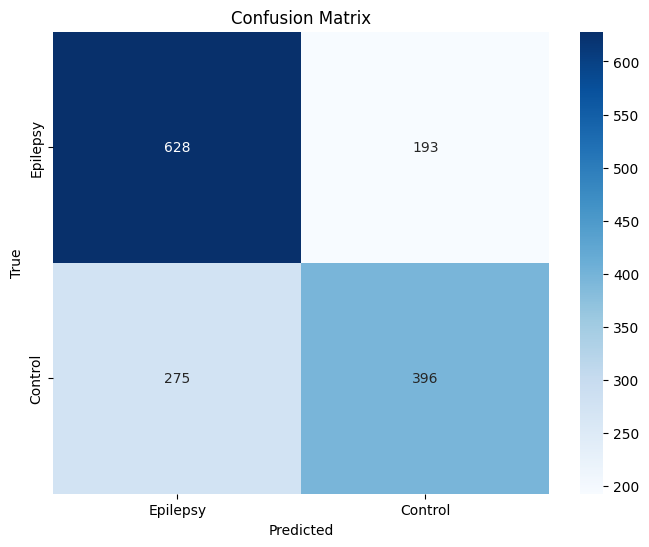

In [ ]:
import seaborn as sns
# Calculate the confusion matrix
confusion = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=['Epilepsy', 'Control'], yticklabels=['Epilepsy', 'Control'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()